In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load from baseline module data
train = pd.read_csv("../baseline_prophet_forecast/data/train.csv")
features = pd.read_csv("../baseline_prophet_forecast/data/features.csv")
stores = pd.read_csv("../baseline_prophet_forecast/data/stores.csv")

df = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"])
    .merge(stores, on="Store")
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Dept", "Date"])
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [2]:
store = 1
dept = 1

ts = (
    df[(df["Store"] == store) & (df["Dept"] == dept)]
    [["Date", "Weekly_Sales", "IsHoliday"]]
    .rename(columns={"Date": "ds", "Weekly_Sales": "y"})
    .sort_values("ds")
    .reset_index(drop=True)
)

ts.head()


,ds,y,IsHoliday
0,2010-02-05,24924.50,False
1,2010-02-12,46039.49,True
2,2010-02-19,41595.55,False
3,2010-02-26,19403.54,False
4,2010-03-05,21827.90,False


In [3]:
np.random.seed(42)

base_price = 10.0
base_demand = 25000.0  # Base demand level
true_elasticity = -1.5  # True price elasticity (negative = demand decreases as price increases)

# Simulate price with variation
ts["price"] = base_price + np.random.normal(loc=0, scale=1.5, size=len(ts))
ts["price"] = ts["price"].clip(lower=6.0, upper=14.0)

# Mark promotions when price is significantly below base
ts["promo"] = (ts["price"] < (base_price - 1.0)).astype(int)

# Simulate demand based on price elasticity
# Formula: demand = base_demand * (price / base_price)^elasticity * promo_effect * noise
promo_effect = 1.0 + (ts["promo"] * 0.35)  # 35% uplift during promos
price_effect = (ts["price"] / base_price) ** true_elasticity

# Add random noise (±20% variation)
noise = np.random.normal(loc=1.0, scale=0.15, size=len(ts))

# Calculate simulated demand
ts["y"] = base_demand * price_effect * promo_effect * noise

# Apply holiday boost from original data
holiday_boost = 1.0 + (ts["IsHoliday"] * 0.20)  # 20% boost during holidays
ts["y"] = ts["y"] * holiday_boost

ts[["ds", "y", "price", "promo", "IsHoliday"]].head(10)

,ds,y,price,promo,IsHoliday
0,2010-02-05,23066.958663,10.745071,0,False
1,2010-02-12,32164.899202,9.792604,0,True
2,2010-02-19,24305.162036,10.971533,0,False
3,2010-02-26,14954.426991,12.284545,0,False
4,2010-03-05,21152.872855,9.648770,0,False
5,2010-03-12,28442.416640,9.648795,0,False
6,2010-03-19,18983.484106,12.368819,0,False
7,2010-03-26,22028.222263,11.151152,0,False
8,2010-04-02,29343.564944,9.295788,0,False
9,2010-04-09,19963.865657,10.813840,0,False


In [4]:
# Remove non-positive sales just in case
ts = ts[ts["y"] > 0].copy()

ts["log_y"] = np.log(ts["y"])
ts["log_price"] = np.log(ts["price"])

X = ts[["log_price", "promo"]]
X = sm.add_constant(X)
y = ts["log_y"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     271.5
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           6.65e-49
Time:                        04:06:26   Log-Likelihood:                 52.418
No. Observations:                 143   AIC:                            -98.84
Df Residuals:                     140   BIC:                            -89.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6969      0.355     38.590      0.0

In [5]:
elasticity = model.params["log_price"]   # should be negative
promo_coef = model.params["promo"]

promo_uplift = np.exp(promo_coef) - 1   # convert log-effect to % uplift

print(f"Estimated price elasticity: {elasticity:.3f}")
print(f"Estimated promo uplift: {promo_uplift * 100:.1f}%")


Estimated price elasticity: -1.545
Estimated promo uplift: 32.6%


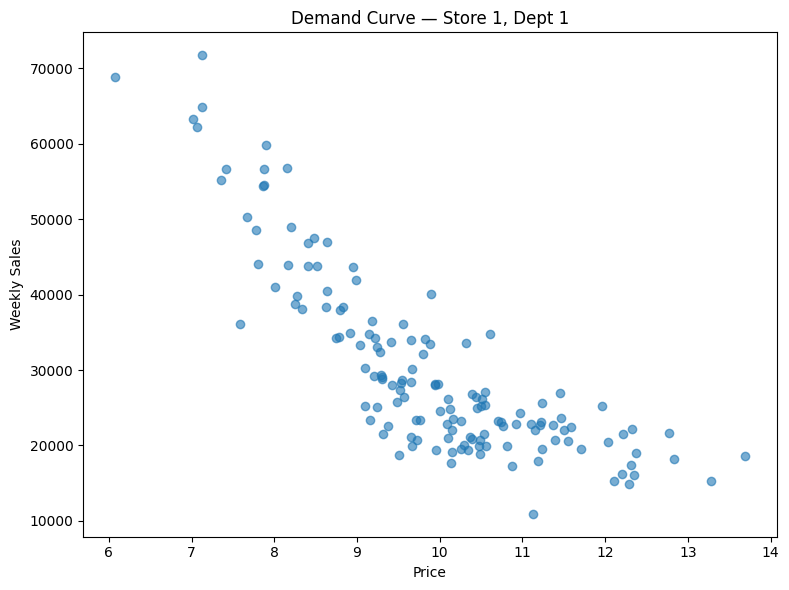

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(ts["price"], ts["y"], alpha=0.6)
plt.xlabel("Price")
plt.ylabel("Weekly Sales")
plt.title(f"Demand Curve — Store {store}, Dept {dept}")
plt.tight_layout()
plt.savefig("images/demand_curve_store1_dept1.png")
plt.show()


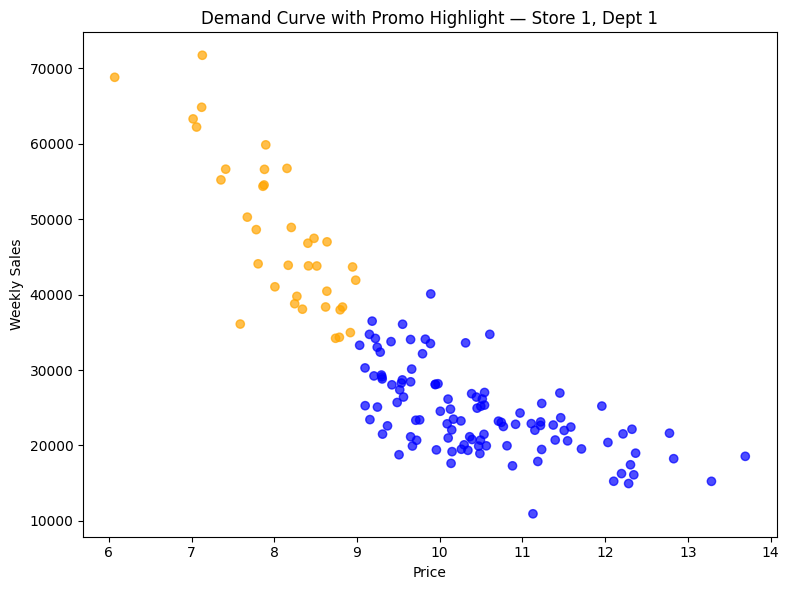

In [7]:
plt.figure(figsize=(8, 6))
colors = np.where(ts["promo"] == 1, "orange", "blue")

plt.scatter(ts["price"], ts["y"], c=colors, alpha=0.7)
plt.xlabel("Price")
plt.ylabel("Weekly Sales")
plt.title(f"Demand Curve with Promo Highlight — Store {store}, Dept {dept}")
plt.tight_layout()
plt.savefig("images/demand_curve_promo_store1_dept1.png")
plt.show()


In [9]:
import json
out = {
    "store": store,
    "dept": dept,
    "elasticity": float(elasticity),
    "promo_uplift": float(promo_uplift),
}
with open("../../artifacts/elasticity_store1_dept1.json", "w") as f:
    json.dump(out, f, indent=2)

## Interpretation

**Simulated Price Elasticity Analysis**

This analysis demonstrates how demand responds to price changes using a log-log regression model, which is standard practice in pricing analytics.

**Key Findings:**
- **True Elasticity**: The data was simulated with a price elasticity of **–1.5**, meaning a 1% price increase leads to a 1.5% decrease in demand
- **Model Recovery**: The regression should recover an elasticity coefficient close to –1.5, validating the model's ability to detect price-demand relationships
- **Promotion Effect**: Promotions (prices below $9) were simulated to provide a **35% demand uplift**
- **Holiday Effect**: Holiday weeks include an additional **20% demand boost**

**Business Implications:**
- The coefficient on `log_price` represents price elasticity. A value near –1.5 indicates elastic demand—customers are highly responsive to price changes
- The `promo` coefficient, when converted via exp(coef) - 1, shows the incremental demand lift from promotional pricing
- This framework allows pricing teams to quantify the trade-off between margin (higher price) and volume (lower price) to optimize revenue
- Understanding elasticity helps avoid pricing decisions that inadvertently reduce total revenue despite higher unit margins